# Multiclass Classification Project

Learning Goals
- How to read different size images from a directory?
- How to implement One-vs-one scheme for Multiclass classification?
- How to use SVM for image classifcation?


In [33]:
import numpy as np
import os
from pathlib import Path
from keras_preprocessing import image
import matplotlib.pyplot as plt

In [2]:
p = Path('images/')
dirs = p.glob('*')

label_dict = {'cats':0, 'horses':1, 'humans':2, 'dogs':3}

image_data = []
labels = []

for folder_name in dirs:
    
    #print(folder_name)
    label = str(folder_name).split('/')[-1]
    
    for image_path in folder_name.glob('*.jpg'):
        
        img = image.load_img(image_path,target_size=(32, 32))
        img_array = image.img_to_array(img)
        image_data.append(img_array)
        labels.append(label_dict[label])

In [3]:
#print(len(image_data))
#print(len(labels))

img_data = np.array(image_data, dtype='float32')/255.0   ##Normalizing the data
labels = np.array(labels)

print(img_data.shape)
print(labels.shape)

(808, 32, 32, 3)
(808,)


In [4]:
import random

combined = list(zip(img_data,labels))       ## so that the corresponding label of each img remains same
random.shuffle(combined)

#Unzip
img_data[:], labels[:] = zip(*combined)

# Visualizing the data

In [5]:
def drawImg(image):
    
    from matplotlib import pyplot as plt
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    return

for ix in range(10):
   
    drawImg(img_data[ix])

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

# Implementing One vs One Scheme

In [6]:
M = img_data.shape[0]
img_data = img_data.reshape(M, -1)       ## flattening the images for the model

print(img_data.shape)
print(labels.shape)

(808, 3072)
(808,)


In [7]:
Classes = len(np.unique(labels))
print(Classes)

4


In [8]:
def classWiseData(X, y):
    
    data = {}
    
    for ix in range(Classes):
        data[ix] = []
        
    for ix in range(X.shape[0]):
        data[y[ix]].append(X[ix])
    
    for ix in data.keys():
        data[ix] = np.array(data[ix])
        
    return data

In [9]:
data = classWiseData(img_data,labels)

In [10]:
print(data[0].shape)
print(data[1].shape)
print(data[2].shape)
print(data[3].shape)

(202, 3072)
(202, 3072)
(202, 3072)
(202, 3072)


In [11]:
## combines data of two classes into a single matrtix for one vs one classification in a svm
def DataPair_for_SVM(d1, d2):
    
    l1,l2 = d1.shape[0], d2.shape[0]
    
    samples = l1+l2
    features = d1.shape[1]
    
    data_pair = np.zeros((samples, features))
    data_labels = np.zeros((samples,))
    
    data_pair[:l1,:] = d1
    data_pair[l1:,:] = d2
    
    data_labels[:l1] = -1
    data_labels[l1:] = +1
    
    return data_pair, data_labels

# SVM Classifier

In [12]:
class SVM:
    
    def __init__(self,C=1.0):
        self.C = C
        self.W = 0
        self.b = 0
        
    def hinge_loss(self,W,b,X_data,y_data):
        
        loss = 0
        loss += 0.5*np.dot(W,W.T)
        
        for ix in range(X_data.shape[0]):
            ti = y_data[ix]*(np.dot(W,X_data[ix].T)+b)
            loss += self.C*max(0,(1-ti))
        
        return loss[0][0]
    
    def fit(self,X_data,y_data,batch_size=100,learning_rate=0.001,maxItr=300):
        
        no_of_features = X_data.shape[1]
        no_of_samples = X_data.shape[0]
        
        n = learning_rate
        c = self.C
        
        #Initialize the model parameters
        
        W = np.zeros((1,no_of_features))
        bias = 0
        
        #print(self.hinge_loss(W,bias,X_data,y_data))
        
        #Training of the data
        #weight and bias update rule
        
        losses = []
        
        for ix in range(maxItr):     ## Training loop
            
            l = self.hinge_loss(W,bias,X_data,y_data)
            losses.append(l)
            ids = np.arange(no_of_samples)
            np.random.shuffle(ids)
            
            # Batch gradient descent with random shuffling
            for batch_start in range(0,no_of_samples,batch_size):
                
                gradw = 0       ## assume zero grad for the batch
                gradb = 0
                
                for jx in range(batch_start,batch_start+batch_size):
                    
                    if jx<no_of_samples:                          ## so the no of batch not exceeeds sample no.
                        idx = ids[jx]
                        ti = y_data[idx]*(np.dot(W,X_data[idx].T)+bias)
                        
                        if ti>1:
                            gradw += 0
                            gradb += 0
                            
                        else:
                            gradw += c*y_data[idx]*X_data[idx]
                            gradb += c*y_data[idx]
                
                ##updation
                
                W = W - n*W + n*gradw
                bias = bias + n*gradb
                
            
        self.W = W
        self.b = bias
            
        return W,bias,losses

# Training NC2 SVMs

In [13]:
mySVM = SVM()

In [27]:
def trainSVMs(X_data,y_data):
    
    svm_classifier = {}
    
    for ix in range(Classes):
        svm_classifier[ix] = {}
        
        for jx in range(ix+1,Classes):
            xpair, ypair = DataPair_for_SVM(data[ix], data[jx])        ## NC2 permutation pairs for classes
            wts,b,loss = mySVM.fit(xpair,ypair,learning_rate=0.00001,maxItr=1000)
            svm_classifier[ix][jx] = (wts,b)
            
            plt.plot(loss)
            plt.show()
    
    return svm_classifier

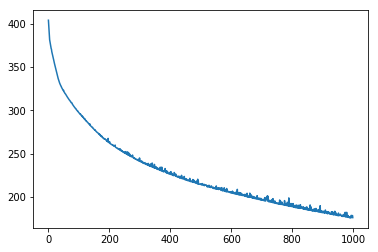

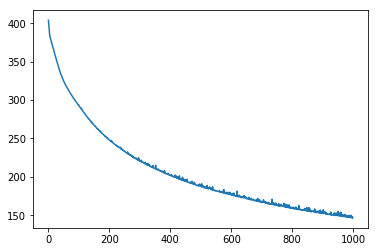

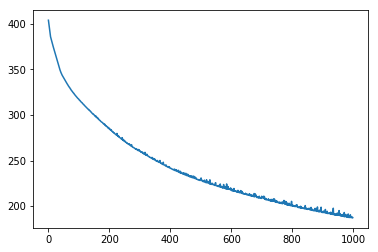

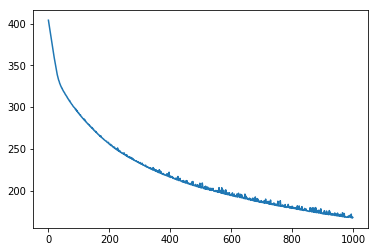

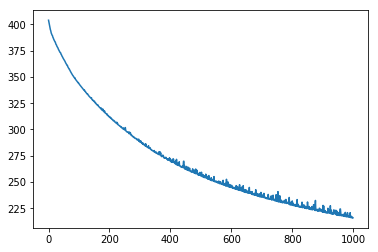

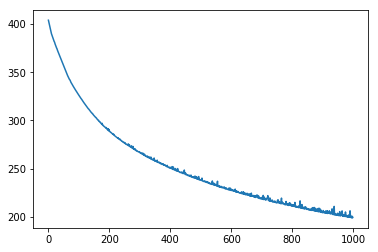

{0: {1: (array([[ 0.02243341,  0.03211028,  0.04653981, ...,  0.01181269,
            0.0180344 , -0.01814577]]), -0.14638000000000073),
  2: (array([[0.02235058, 0.03823819, 0.05213202, ..., 0.03366078, 0.03766633,
           0.01297881]]), -0.07609999999999996),
  3: (array([[ 0.0156035 ,  0.02420656,  0.03402838, ..., -0.00561743,
            0.00167816, -0.02563718]]), -0.04102)},
 1: {2: (array([[0.01403901, 0.00951272, 0.01719157, ..., 0.04041695, 0.04147488,
           0.05530721]]), 0.03491999999999991),
  3: (array([[-0.00422275, -0.00630638, -0.01197151, ..., -0.00263295,
           -0.00362196,  0.01549069]]), 0.07776000000000005)},
 2: {3: (array([[-0.02076259, -0.02082534, -0.02645353, ..., -0.03398183,
           -0.03495718, -0.03532921]]), 0.04995999999999981)},
 3: {}}

In [34]:
trainSVMs(img_data,labels)

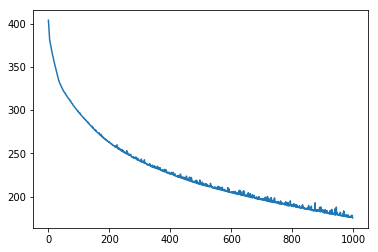

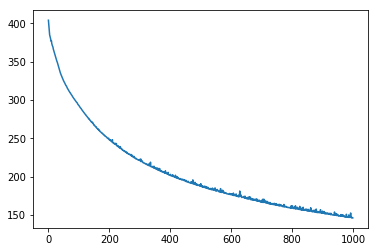

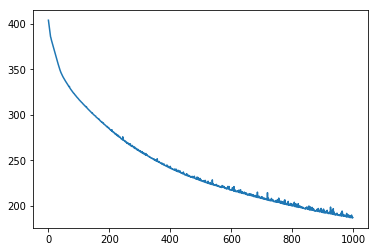

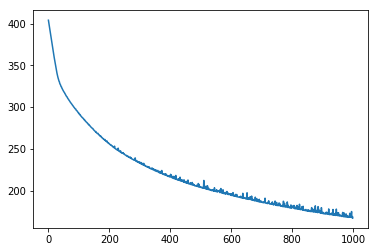

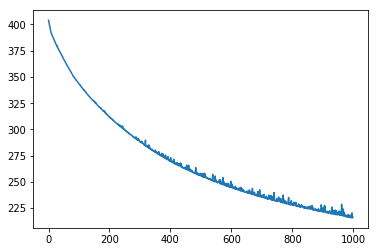

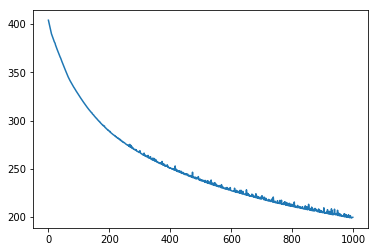

In [35]:
svm_classifier = trainSVMs(img_data, labels)

In [36]:
## Parametrs for cats_horses

cats_horses = svm_classifier[0][1]

print(cats_horses[0].shape)
print(cats_horses[1])

(1, 3072)
-0.14662000000000067


# Prediction

In [37]:
def binaryPredict(X,w,b):
    
    z = np.dot(X,w.T) + b
    
    if z >= 0:
        return 1
    else:
        return -1    

In [38]:
def predict(X):
    
    count = np.zeros((Classes,))
    
    for i in range(Classes):
        for j in range(1+i,Classes):
            
            w,b = svm_classifier[i][j]
            # majority prediction
            z = binaryPredict(X,w,b)
            
            if z == 1:
                count[j] += 1
            else:
                count[i] += 1
    
    final_pred = np.argmax(count)
    return final_pred

In [39]:
print(predict(img_data[1]))
print(labels[1])

2
2


In [40]:
def accuracy(X,y):
    
    count = 0
    for i in range(X.shape[0]):
        pred = predict(X[i])
        if pred == y[i]:
            count += 1
    
    return count/X.shape[0]

In [41]:
print(accuracy(img_data,labels))

0.5853960396039604


# Scikit

In [42]:
from sklearn import svm

In [43]:
svm_classifier = svm.SVC(kernel='linear', C=1.0)

In [44]:
svm_classifier.fit(img_data, labels)
svm_classifier.score(img_data, labels)

0.6361386138613861